<a href="https://colab.research.google.com/github/jjc16/Project_Notebooks/blob/master/Variational_Autoencoder_for_Image_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder for Image Embedding

This notebook demonstrates development of a fast prototype for ranking similar images in an input training set. 

## Background: 
Variational autoencoders expand traditional autoencoders by using a trained Linear layer to shape the latent space in a traditional autoencoder to have normally distributed values. It does this by 
  - training the Linear layer by taking the KL-divergence between the transformed latent space and a $N (0,1)$ distribution (where $N$ is the normal distribution) and 
  - sampling the reconstructed images from the latent space (assuming a normal distribution) and using the sampled images to calculate the reconstruction loss

## Novelties in notebook

This notebook also adds a classification head that inputs the latent space and outputs logits for each class in the dataset. The idea here is to not only identify close images (in the latent space) but also return the probable classes.

## References:

The author utilized several third-party sources to create this notebook:

- Data source: http://aws-proserve-data-science.s3.amazonaws.com/geological_similarity.zip 

- PyTorch Lightning Bolts: https://pytorch-lightning-bolts.readthedocs.io/

If you wish to use any code from this notebook in your project, please contact the author: j j c 1 6 [at] y a h o o . c o m. The author makes no warranty, express or implied, about the suitability of this code for any project.

We start by installing PyTorch Lighting Bolts (moved to end of notebook)

## Imports

We need to import the needed libraries

In [3]:
import torch
from pl_bolts.models.autoencoders import VAE
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
%matplotlib inline
import torchvision
import pytorch_lightning as pl
import pandas as pd

device = 'cuda:0'

## Connect data storage location

Now, we connect the data, show a sample image, print the max and min values, and display the shape of the data

Picture Min value: 63
Picture Max value: 198
Picture Shape: (28, 28, 3)


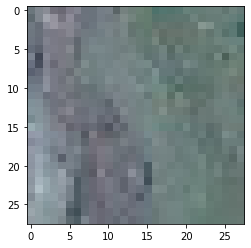

In [4]:
pth = '/content/drive/MyDrive/geo_sim/geological_similarity/andesite/01LQQ.jpg'
with Image.open(pth,'r') as im:
  data = np.asarray(im)
imshow(data)
print(f'Picture Min value: {np.min(data)}')
print(f'Picture Max value: {np.max(data)}')
print(f'Picture Shape: {data.shape}')

## Transforms

We will be using a Resnet18 model for the image encoder and decoder. To do this, our images need to be at least size 32 x 32. Also, we need to normalize the images (using values explained in the Resnet18 documentation) and turn the outputs into tensors for model ingestion. The results of doing this are below:

In [5]:
trans_norm = torchvision.transforms.Normalize((0.485, 0.456, 0.406), 
                                         (0.229, 0.224, 0.225))
trans_resize = torchvision.transforms.Resize(size=(32,32))
trans_ten = torchvision.transforms.ToTensor()
# trans_un = torchvision.transforms.Lambda(lambda x: torch.unsqueeze(x,0))
trans_comp = torchvision.transforms.Compose([trans_ten, trans_resize, trans_norm])
out = trans_comp(data)
print(out.shape)
print(data.shape)

torch.Size([3, 32, 32])
(28, 28, 3)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


## Model:

Now, we create a variational autoencoder model (VAE). We utilize PyTorch Lighting Bolts to skip writing boilerplate code and greatly accelerate our development

In [6]:
model = VAE(input_height=32)
print(model)


VAE(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

## Datasets and Dataloader:

We now create PyTorch Datasets and DataLoaders for the training, validation, and test data

In [7]:
ds = torchvision.datasets.ImageFolder('/content/drive/MyDrive/geo_sim/geological_similarity', transform=trans_comp)
from math import floor
tr_len = floor(0.8*len(ds))
val_ln = floor(0.1*len(ds))
tst_ln = len(ds) - tr_len - val_ln
train_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_ln, tst_ln])
print(len(train_ds), len(val_ds), len(test_ds))
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, num_workers=2)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=64, num_workers=2)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, num_workers=2)

23999 2999 3001


## Custom VAE Model

The VAE model that is created by default doesn't have quite the features that we want. We also want to add a linear classification head to it to predict the classes of the encoded images. To do this, we create a custom model with a an extra linear layer and an overriden step function

In [8]:
class CustomVAE(VAE):
  def __init__(self, *args, num_classes=6, **kwargs):
    super().__init__(*args, **kwargs)
    self.classification_head = torch.nn.Linear(self.latent_dim, num_classes)

  def step(self, batch, batch_idx, alpha=0.1):
    loss, logs = super().step(batch, batch_idx)
    enc = self.encoder(batch[0])
    enc_mu = self.fc_mu(enc)
    x_cl = self.classification_head(enc_mu)
    labels = batch[1]
    # print(labels.shape)
    # print(x_cl.shape)
    loss_class = alpha*torch.nn.CrossEntropyLoss()(x_cl, labels)
    loss = loss + loss_class
    # if batch_idx % 10 ==0:
    #   print(batch_idx)
    return loss, logs


In [9]:
cust_model = CustomVAE(input_height=32)
# model = MyLightningModule
cust_model.load_from_checkpoint('/content/drive/MyDrive/model.ckpt')
#params = torch.load('/content/drive/MyDrive/lightning_logs/lightning_logs/version_0/checkpoints/hparams.yaml')
# model=pl.LightningModule.load_from_checkpoint('/content/drive/MyDrive/lightning_logs/lightning_logs/version_0/checkpoints/vae_model.ckpt')

CustomVAE(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

## PyTorch Lighting Bolts Trainer

Now, we create a trainer and use the .fit method to fit to our data

In [10]:
# tr = pl.Trainer(max_epochs=20, gpus=1,progress_bar_refresh_rate=1, default_root_dir='/content/drive/MyDrive/lightning_logs/')
# tr.fit(cust_model, train_dataloader=train_dl, val_dataloaders=val_dl)
# tr.save_checkpoint('/content/drive/MyDrive/model.ckpt')

## Image embedding

Once we are satisfied with the results of the model training, we can use the trained model to embed the images. The process of embedding can take a long time because we have to do several inferences through the model. However, these embeddings can be precomputed and stored in a file for later search.

Below, we first get a list of files.

In [197]:
import os
pth = '/content/drive/MyDrive/geo_sim/geological_similarity/'
out = []
for path, subdirs, files in os.walk(pth):
    for name in files:
      if name[0] != '.':
        out.append(os.path.join(path, name))
print(len(out))

29999


In [44]:
# fl = out[20000]
# img = Image.open(fl)
# img = np.asarray(img)
# # img = cust_model(trans_comp(img).unsqueeze(0))
# enc = cust_model.encoder(trans_comp(img).unsqueeze(0))
# enc = cust_model.fc_mu(enc).squeeze()
# enc.shape

torch.Size([256])

Next, we embed the images

In [47]:
# from PIL import Image
# img_paths = []
# img_emb_list = []
# for ii, fl in enumerate(out):
#   if ii % 100 == 0:
#     print(f'Iter: {ii}')
#     # print(enc.shape)
#   img = Image.open(fl)
#   img = np.asarray(img)
#   # img = cust_model(trans_comp(img).unsqueeze(0))
#   enc = cust_model.encoder(trans_comp(img).unsqueeze(0))
#   enc = cust_model.fc_mu(enc).squeeze()
#   img = enc.detach().numpy()
#   img_paths.append(fl)
#   img_emb_list.append(img)

# data_tuples = list(zip(img_paths, img_emb_list))
# df = pd.DataFrame(data_tuples, columns=['Image Path', 'Image Embeding'])
# df.to_csv('/content/drive/MyDrive/geo_sim/' + 'image_embeddings.csv')

Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 500
Iter: 600
Iter: 700
Iter: 800
Iter: 900
Iter: 1000
Iter: 1100
Iter: 1200
Iter: 1300
Iter: 1400
Iter: 1500
Iter: 1600
Iter: 1700
Iter: 1800
Iter: 1900
Iter: 2000
Iter: 2100
Iter: 2200
Iter: 2300
Iter: 2400
Iter: 2500
Iter: 2600
Iter: 2700
Iter: 2800
Iter: 2900
Iter: 3000
Iter: 3100
Iter: 3200
Iter: 3300
Iter: 3400
Iter: 3500
Iter: 3600
Iter: 3700
Iter: 3800
Iter: 3900
Iter: 4000
Iter: 4100
Iter: 4200
Iter: 4300
Iter: 4400
Iter: 4500
Iter: 4600
Iter: 4700
Iter: 4800
Iter: 4900
Iter: 5000
Iter: 5100
Iter: 5200
Iter: 5300
Iter: 5400
Iter: 5500
Iter: 5600
Iter: 5700
Iter: 5800
Iter: 5900
Iter: 6000
Iter: 6100
Iter: 6200
Iter: 6300
Iter: 6400
Iter: 6500
Iter: 6600
Iter: 6700
Iter: 6800
Iter: 6900
Iter: 7000
Iter: 7100
Iter: 7200
Iter: 7300
Iter: 7400
Iter: 7500
Iter: 7600
Iter: 7700
Iter: 7800
Iter: 7900
Iter: 8000
Iter: 8100
Iter: 8200
Iter: 8300
Iter: 8400
Iter: 8500
Iter: 8600
Iter: 8700
Iter: 8800
Iter: 8900
Iter: 9000
Iter: 9100


In [166]:
def conv(x):
  tst = x.strip('[]').split()
  tst2 = [float(t) for t in tst]
  tst3 = np.array(tst2)
  
  return tst3

Then, we put the embeddings in a dataframe and save the results

## Search Images

When we're ready to perform the search, we simply load the precomputed embeddings, calculate the distance between each embedding and the embedding of the target image and return the closest images (the minimum distances).

In [204]:
df = pd.read_csv('/content/drive/MyDrive/geo_sim/' + 'image_embeddings.csv')
from scipy.spatial.distance import cosine
def search(model, df, img_path, n=5):
  ''' Returns a list of nearest images for an input image

  Inputs: model - the model to embed the image
          df - a dataframe containing images previously embedded using the
               embedding model. Should have columns = ['Image Path',
               'Image Embedding']
          img_path - the path to the test image
          n [optional] - the number of nearest images to return

  Returns - a dataframe containing information on the nearest images
  '''
  tmp_df = df.copy()
  # print(tmp_df.head())
  lst = []
  for ii in range(len(tmp_df)):
    tmp2 = conv(tmp_df.iloc[ii,2])
    lst.append(tmp2)
  tmp_df['Image Embeding'] = lst
  # print(tmp_df.head())

  img = Image.open(img_path)
  img = np.asarray(img)
  emb = cust_model.encoder(trans_comp(img).unsqueeze(0))
  # print(emb.shape)
  emb = cust_model.fc_mu(emb)
  emb = emb.detach().numpy().squeeze()
  # print(emb.shape)
  func = lambda x: cosine(x, emb)
  lst = tmp_df['Image Embeding']
  lst2 = lst.apply(func,2)
  # print(tmp_df.head)
  tmp_df['Image Embeding'] = lst2
  img_out = tmp_df.sort_values(by='Image Embeding')

  return img_out

In [223]:
out_img = search(cust_model, df, out[1000])

Now, we spot check some of the returned values:

In [224]:
print(out_img.iloc[0,1])
print(out_img.iloc[1,1])
print(out_img.iloc[2,1])
print(out_img.iloc[3,1])
print(out_img.iloc[4,1])

/content/drive/MyDrive/geo_sim/geological_similarity/quartzite/LSIXH.jpg
/content/drive/MyDrive/geo_sim/geological_similarity/quartzite/6P5LU.jpg
/content/drive/MyDrive/geo_sim/geological_similarity/quartzite/PLHJO.jpg
/content/drive/MyDrive/geo_sim/geological_similarity/quartzite/0JF0L.jpg
/content/drive/MyDrive/geo_sim/geological_similarity/quartzite/4G9KA.jpg


Viola!

## Installations

In [ ]:
# !pip install torch
!pip install lightning-bolts["extra"]

## Pip Freeze

In [1]:
!pip freeze > /content/drive/MyDrive/requirements.txt
!cat /content/drive/MyDrive/requirements.txt

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
arviz==0.11.2
astor==0.8.1
astropy==4.2.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.3.2
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cached-property==1.5.2
cachetools==4.2.2
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.5
cftime==1.5.0
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.23
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.3
distributed=